---

Created for [learn-investments.rice-business.org](https://learn-investments.rice-business.org)
    
By [Kerry Back](https://kerryback.com) and [Kevin Crotty](https://kevin-crotty.com)
    
Jones Graduate School of Business, Rice University

---


# EXAMPLE DATA

In [1]:
# means
mn1 = 0.08
mn2 = 0.12
mn3 = 0.15

# std devs
sd1 = 0.15
sd2 = 0.25
sd3 = 0.35

# correlations
c12 = 0.15
c13 = 0.60
c23 = 0.30

# risk-free rate
rf = 0.02

# CREATE ARRAYS

In [2]:
import numpy as np

mn = np.array([mn1, mn2, mn3])
sd = np.array([sd1, sd2, sd3])

corr = np.identity(3)
corr[0, 1] = corr[1, 0] = c12
corr[0, 2] = corr[2, 0] = c13
corr[1, 2] = corr[2, 1] = c23

cov = np.diag(sd) @ corr @ np.diag(sd)

# CHECK CORRELATIONS

In [3]:
if np.all(np.linalg.eigvals(cov) > 0):
    print("correlations are acceptable")
else:
    print("correlations are inconsistent")

correlations are acceptable


# CALCULATE FRONTIER OF RISKY ASSETS

In [4]:
# global minimum variance portfolio
w = np.linalg.solve(cov, np.ones(3))
gmv = w / np.sum(w)
gmv_mn = gmv @ mn
gmv_sd = np.sqrt(gmv @ cov @ gmv)

# second frontier portfolio
w = np.linalg.solve(cov, mn)
second_port = w / np.sum(w)
second_mn = second_port @ mn
second_sd = np.sqrt(second_port @ cov @ second_port)

# means to display
min_mn = -0.1
max_mn = 1.5*np.max(mn)
mns = np.linspace(min_mn, max_mn, 101)

# portfolio weights and risks
gmv_wt = (mns - second_mn) / (gmv_mn - second_mn)
second_wt = 1 - gmv_wt
ports = (
    gmv_wt.reshape(-1, 1) * gmv.reshape(1, -1) +
    second_wt.reshape(-1, 1) * second_port.reshape(1, -1)
)
vr = np.diag(ports @ cov @ ports.T)
sds = np.sqrt(vr)


# CALCULATE TANGENCY PORTFOLIO

In [5]:
if gmv_mn < rf:
    print(
        """
        Figure will be incorrect.  For these parameter values, all
        efficient portfolios involve shorting risky assets and investing
        more than 100% at the savings rate.
        """
    )

In [6]:
tang = np.linalg.solve(cov, mn-rf)
tang = tang / np.sum(tang)
tang_mn = tang @ mn
tang_sd = np.sqrt(tang @ cov @ tang)

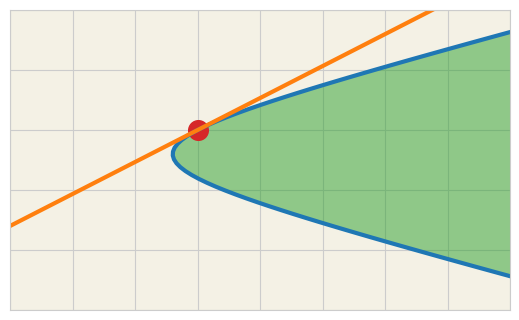

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid", {'axes.facecolor': '#f4f1e5'})
colors = sns.color_palette()
# Set the figure size to (5, 3) inches
plt.figure(figsize=(5, 3))

plt.plot(sds, mns, lw=3)

# Fill the area to the right of the efficient frontier curve
plt.fill_betweenx(mns, sds, max(sds)*1.2, alpha=0.5, color=colors[2])

# Set font sizes to 14pt for all labels


# Add labels and title
plt.xlabel('')
plt.ylabel('')

# Remove tick labels
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Set x-axis limit to ensure the filled area is visible
plt.xlim(0, 0.4)
plt.ylim(-0.05, 0.2)

plt.scatter([tang_sd], [tang_mn], s=200, color=colors[3])
plt.plot([0, 0.4], [rf, rf+0.4*(tang_mn-rf)/tang_sd], color=colors[1], lw=3)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("../posts/07-mean-variance/tangency.png")




# FIGURE

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
plotly_template = pio.templates["simple_white"]
colors = plotly_template.layout.colorway

# frontier of risky assets
string = 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace1 = go.Scatter(
    x=sds,
    y=mns,
    mode="lines",
    customdata=ports,
    hovertemplate=string
)

# three assets
trace2 = go.Scatter(
    x=sd,
    y=mn,
    text=["Asset 1", "Asset 2", "Asset 3"],
    hovertemplate="%{text}<extra></extra>",
    mode="markers",
    marker=dict(size=15)
)

# tangency portfolio
string = "tangency portfolio<br>"
string += 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace3 = go.Scatter(
    x=[tang_sd],
    y=[tang_mn],
    customdata=tang.reshape(1, -1),
    hovertemplate=string,
    mode="markers",
    marker=dict(size=15)
)

# frontier including risk-free asset
ports = np.arange(0, 2.01, 0.01).reshape(-1, 1) * tang.reshape(1, -1)
x = np.sqrt(np.diag(ports @ cov @ ports.T))
y = rf + ports @ (mn-rf)
string = 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace4 = go.Scatter(
    x=x,
    y=y,
    mode="lines",
    customdata=ports,
    hovertemplate=string,
    line=dict(color=colors[5])
)

fig = go.Figure()
for trace in (trace1, trace2, trace3, trace4):
    fig.add_trace(trace)

fig.update_layout(
    xaxis_title="Standard Deviation",
    yaxis_title="Expected Return",
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    template="plotly_white",
    showlegend=False
)
fig.show()